In [1]:
import sys,os,os.path
sys.path.append(os.path.expanduser('~/Codes/SolutionDistillation'))
import numpy as np
import tensorflow as tf
import os
from distill.common.hparams import TransformerHparam, LSTMHparam
from distill.data_util.prep_algorithmic import AlgorithmicIdentityDecimal40, AlgorithmicAdditionDecimal40, \
  AlgorithmicMultiplicationDecimal40, AlgorithmicSortProblem, AlgorithmicReverseProblem, AlgorithmicIdentityBinary40
from distill.data_util.prep_arithmatic import Arithmatic, ArithmaticSimpleSameLength10, ArithmaticSimpleSameLength21Depth2Zipfian, \
ArithmaticSimpleSameLength21Depth2Normal, ArithmaticSimpleSameLength201Depth2Normal
from distill.data_util.prep_imdb import IMDB
from distill.data_util.prep_ptb import PTB
from distill.data_util.prep_sst import SST
from distill.data_util.prep_wsj_parsing import ParseWSJ
from distill.models.lstm_seq2seq import LSTMSeq2Seq, BidiLSTMSeq2Seq
from distill.models.transformer import Transformer, UniversalTransformer, EncodingTransformer, \
  EncodingUniversalTransformer
from distill.pipelines.seq2seq import Seq2SeqTrainer
from distill.models.transformer import Transformer, UniversalTransformer, EncodingTransformer, \
  EncodingUniversalTransformer
from distill.pipelines.distill_pipelines import Seq2SeqDistiller
from distill.pipelines.seq2seq import Seq2SeqTrainer

# Enable TF Eager execution
tfe = tf.contrib.eager
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys

In [2]:

task = ArithmaticSimpleSameLength201Depth2Normal('data/arithmatic_simple_samelength201_depth2_normal')

transformer_params = TransformerHparam(input_dim=task.vocab_length,
                                         hidden_dim=300,
                                         output_dim=len(task.target_vocab),
                                         encoder_depth=2,
                                         decoder_depth=1,
                                         number_of_heads=2,
                                         ff_filter_size=512,
                                         initializer_gain=0.1,
                                         batch_size=32,
                                         input_dropout_keep_prob=1.0,
                                         hidden_dropout_keep_prob=1.0,
                                         vocab_size=task.vocab_length,
                                         label_smoothing=0.1,
                                         encoder_self_attention_dir="top_down",
                                         decoder_self_attention_dir="top_down",
                                         decoder_cross_attention_dir="top_down",
                                         train_embeddings=False,
                                         learning_rate=0.001
                                         )
trainer = Seq2SeqTrainer(transformer_params, None, task)



In [3]:
train_dataset = tf.data.TFRecordDataset("../"+task.get_tfrecord_path(mode="train"))
train_dataset = train_dataset.map(task.parse_examples)
train_dataset = train_dataset.padded_batch(50000, padded_shapes=task.get_padded_shapes())
train_dataset = train_dataset.map((lambda x1,x2,x3,x4: ((x1,x2,x3,x4),(x1,x2,x3,x4))))
train_dataset = train_dataset.shuffle(buffer_size=100)
train_dataset = train_dataset.repeat()

train_examples = tfe.Iterator(train_dataset).next()



dev_dataset = tf.data.TFRecordDataset("../"+task.get_tfrecord_path(mode="dev"))
dev_dataset = dev_dataset.map(task.parse_examples)
dev_dataset = dev_dataset.padded_batch(1000, padded_shapes=task.get_padded_shapes())
dev_dataset = dev_dataset.shuffle(buffer_size=100)
dev_dataset = dev_dataset.repeat()

dev_examples = tfe.Iterator(dev_dataset).next()




test_dataset = tf.data.TFRecordDataset("../"+task.get_tfrecord_path(mode="test"))
test_dataset = test_dataset.map(task.parse_examples)
test_dataset = test_dataset.padded_batch(1000, padded_shapes=task.get_padded_shapes())
test_dataset = test_dataset.shuffle(buffer_size=100)
test_dataset = test_dataset.repeat()

test_examples = tfe.Iterator(test_dataset).next()


Instructions for updating:
Colocations handled automatically by placer.


In [4]:
x,y= train_examples

In [5]:
x[0][0]

<tf.Tensor: id=186, shape=(34,), dtype=int64, numpy=
array([24, 14, 26, 24, 13, 27, 13, 25, 26, 24, 21, 26, 15, 27, 15, 25, 25,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])>

In [6]:
y[1][0]

<tf.Tensor: id=191, shape=(1,), dtype=int64, numpy=array([22])>

In [7]:
def get_stats_from_examples(batched_examples):
    lengthes = []
    targets = []
    for example_inputs, example_targets in zip(batched_examples[0], batched_examples[1]):
        np_example_inputs = example_inputs.numpy()
        np_example_targets = example_targets.numpy()[0]
        if 0 in list(np_example_inputs):
            length = list(np_example_inputs).index(0)
        else:
            length = len(np_example_inputs)
        lengthes.append(length)
        targets.append(np_example_targets)
    return lengthes, targets

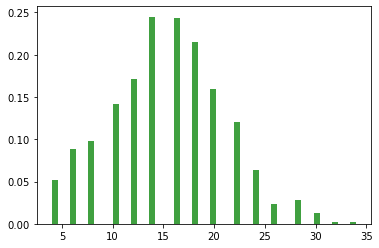

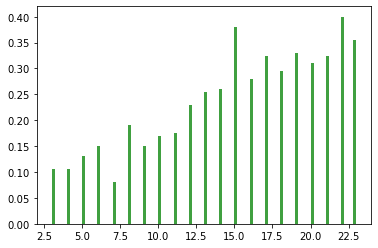

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


lengthes, targets = get_stats_from_examples(train_examples[0])

n, bins, patches = plt.hist(lengthes, 50, density=True, facecolor='g', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(targets, 100, density=True, facecolor='g', alpha=0.75)
plt.show()

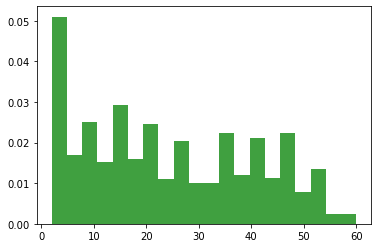

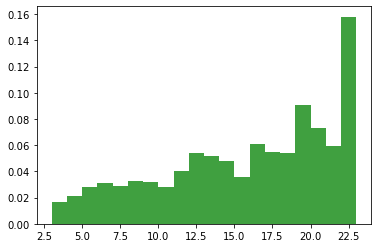

In [9]:


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


lengthes, targets = get_stats_from_examples(dev_examples)

n, bins, patches = plt.hist(lengthes, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(targets, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

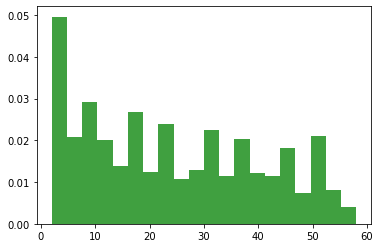

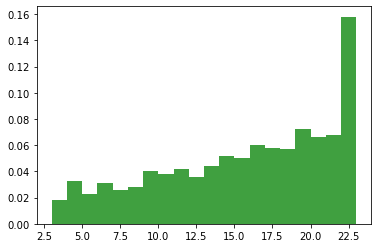

In [10]:


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  


lengthes, targets = get_stats_from_examples(test_examples)

n, bins, patches = plt.hist(lengthes, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

n, bins, patches = plt.hist(targets, 20, density=True, facecolor='g', alpha=0.75)
plt.show()

In [16]:
print(task.decode(task.encode(str("1 + 1").split())))


['1', '+', '1']


In [14]:
i = np.random.randint(len(train_examples[0][0]))
print(i, len(train_examples[0][0]))
example_inputs, example_targets = list(zip(train_examples[0][0], train_examples[0][1]))[i]
print(' '.join(task.decode(example_inputs)).replace('<pad>',''))
print(eval(' '.join(task.decode(example_inputs)).replace('<pad>','').replace('<eos>', '')))

print(task.decode((example_targets)))


print(' '.join(task.decode(example_inputs)).replace('<pad>',''))
print(eval(' '.join(task.decode(example_inputs)).replace('<pad>','').replace('<eos>', '')))

print(example_targets)


581 1000
( 8 - 6 + 9 + 1 - 4 + ( 8 - 7 ) ) <eos>                
9
['9']
( 8 - 6 + 9 + 1 - 4 + ( 8 - 7 ) ) <eos>                
9
tf.Tensor([22], shape=(1,), dtype=int64)


In [15]:
model_1 = EncodingTransformer(transformer_params, task, "model_1")
model_2 = EncodingTransformer(transformer_params, task, "model_2")

trainer = Seq2SeqTrainer(transformer_params, model_1, task)
distiller = Seq2SeqDistiller(transformer_params, model_1, model_2, trainer)
    
trainer.compute_loss(tf.one_hot(example_targets,10),example_targets)

Instructions for updating:
Use tf.cast instead.


InvalidArgumentError: logits and labels must be broadcastable: logits_size=[1,10] labels_size=[1,28] [Op:SoftmaxCrossEntropyWithLogits] name: loss/smoothing_cross_entropy/softmax_cross_entropy_with_logits/

In [20]:
example_targets

<tf.Tensor: id=3622, shape=(1,), dtype=int64, numpy=array([9])>

In [21]:
tf.one_hot(example_targets,16)

<tf.Tensor: id=5344, shape=(1, 16), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [22]:
from distill.common.metrics import padded_cross_entropy_loss, get_eval_metrics, cross_entropy_loss

In [23]:
entropy, weights = cross_entropy_loss(tf.one_hot(example_targets,10),example_targets,smoothing=0.0,vocab_size=10)

In [24]:
weights

<tf.Tensor: id=5410, shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>

In [25]:
entropy

<tf.Tensor: id=5406, shape=(1,), dtype=float32, numpy=array([1.4611502], dtype=float32)>

In [26]:
soft_targets = tf.one_hot(
            tf.cast(example_targets, tf.int32),
            depth=10,
            on_value=1.0,
            off_value=0.0)
              
      
      
xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(
  logits=soft_targets*100, labels=soft_targets)

In [27]:
xentropy

<tf.Tensor: id=5453, shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [28]:
soft_targets

<tf.Tensor: id=5419, shape=(1, 10), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [29]:
tf.one_hot(example_targets,10)

<tf.Tensor: id=5459, shape=(1, 10), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [30]:
model.create_vars()
outputs = model.apply(train_examples)

NameError: name 'model' is not defined

In [23]:
outputs.shape

TensorShape([Dimension(1000), Dimension(1), Dimension(10)])

In [24]:
tf.nn.softmax(outputs)

<tf.Tensor: id=40896, shape=(1000, 1, 10), dtype=float32, numpy=
array([[[0.00715524, 0.09209497, 0.0917704 , ..., 0.03556783,
         0.04943119, 0.15343009]],

       [[0.02895103, 0.04006007, 0.26865193, ..., 0.00580688,
         0.07627358, 0.02107685]],

       [[0.04077142, 0.02672941, 0.23326753, ..., 0.00361042,
         0.04985133, 0.04474999]],

       ...,

       [[0.01969549, 0.02658502, 0.2711329 , ..., 0.00517109,
         0.05861397, 0.04302977]],

       [[0.02205601, 0.05488703, 0.26217592, ..., 0.00449226,
         0.06337234, 0.0239463 ]],

       [[0.04000373, 0.05206897, 0.24202158, ..., 0.01508354,
         0.07866572, 0.02239132]]], dtype=float32)>

In [40]:
outputs['trainable_vars']

[]

In [41]:
model.scope

'Transformer'

In [31]:
g = tf.Graph()
with g.as_default():
    model_1.create_vars(False)
    model_2.create_vars(False)
    print(tf.trainable_variables("model_1"))
    print(tf.trainable_variables("model_2"))

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
[<tf.Variable 'model_1/TransformerEncoder/layer_norm_scale:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'model_1/TransformerEncoder/layer_norm_bias:0' shape=(300,) dtype=float32_ref>]
[<tf.Variable 'model_2/TransformerEncoder/layer_norm_scale:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'model_2/TransformerEncoder/layer_norm_bias:0' shape=(300,) dtype=float32_ref>]


In [35]:
model = EncodingTransformer(transformer_params, task)
model.create_vars(False)
print(tf.trainable_variables())

[]


In [39]:
g = tf.Graph()
with g.as_default():
    model_1.create_vars(False)
    model_2.create_vars(False)
    model_1_vars = tf.trainable_variables("model_1")
    model_2_vars = tf.trainable_variables("model_2")
    print(model_2_vars)
    print(model_1_vars + model_2_vars)

[<tf.Variable 'model_2/TransformerEncoder/layer_norm_scale:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'model_2/TransformerEncoder/layer_norm_bias:0' shape=(300,) dtype=float32_ref>]
[<tf.Variable 'model_1/TransformerEncoder/layer_norm_scale:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'model_1/TransformerEncoder/layer_norm_bias:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'model_2/TransformerEncoder/layer_norm_scale:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'model_2/TransformerEncoder/layer_norm_bias:0' shape=(300,) dtype=float32_ref>]


In [32]:
import scipy.stats as stats

N = 100
numbers = np.arange(1, N+1, 1)
weights = np.arange(N+1,1, -1)
a = 0.6
weights = weights ** (-a)
weights /= weights.sum()
bounded_zipf = stats.rv_discrete(name='bounded_zipf', values=(numbers, weights))

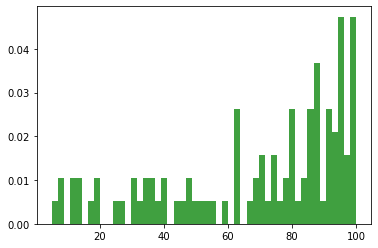

In [33]:
n, bins, patches = plt.hist(bounded_zipf.rvs(size=100), 50, density=True, facecolor='g', alpha=0.75)
plt.show()

In [34]:
list(zip(numbers, weights))

[(1, 0.004856189898673658),
 (2, 0.004885269034112886),
 (3, 0.0049148171919634245),
 (4, 0.004944846790486446),
 (5, 0.004975370707886058),
 (6, 0.005006402304302833),
 (7, 0.0050379554451011445),
 (8, 0.005070044525540879),
 (9, 0.005102684496931644),
 (10, 0.005135890894375523),
 (11, 0.005169679866213408),
 (12, 0.005204068205299506),
 (13, 0.005239073382239342),
 (14, 0.005274713580738159),
 (15, 0.00531100773521946),
 (16, 0.0053479755708875235),
 (17, 0.005385637646423206),
 (18, 0.005424015399519461),
 (19, 0.005463131195481844),
 (20, 0.005503008379140095),
 (21, 0.005543671330339965),
 (22, 0.005585145523309882),
 (23, 0.005627457590225439),
 (24, 0.005670635389325939),
 (25, 0.005714708077972236),
 (26, 0.005759706191073838),
 (27, 0.005805661725356555),
 (28, 0.005852608229990211),
 (29, 0.005900580904149895),
 (30, 0.0059496167021445955),
 (31, 0.005999754446814743),
 (32, 0.006051034951976069),
 (33, 0.006103501154772683),
 (34, 0.0061571982588983195),
 (35, 0.00621217388

In [61]:
train_examples[0][0]

<tf.Tensor: id=33435, shape=(1000, 60), dtype=int64, numpy=
array([[14, 26, 19, ...,  0,  0,  0],
       [24, 19, 27, ...,  0,  0,  0],
       [24, 18, 26, ...,  0,  0,  0],
       ...,
       [24, 15, 26, ...,  0,  0,  0],
       [24, 17, 27, ...,  0,  0,  0],
       [24, 22, 27, ...,  0,  0,  0]])>

In [21]:
copy = 0
for ex in test_examples[0].numpy():
    if ex in train_examples[0][0].numpy():
        copy +=1
print(copy)

copy = 0
for ex in dev_examples[0].numpy():
    if ex in train_examples[0][0].numpy():
        copy +=1
print(copy)

/anaconda/envs/std/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


0


/anaconda/envs/std/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


0


In [83]:
train_examples[0][0].numpy()

array([[14, 26, 19, ...,  0,  0,  0],
       [24, 19, 27, ...,  0,  0,  0],
       [24, 18, 26, ...,  0,  0,  0],
       ...,
       [24, 15, 26, ...,  0,  0,  0],
       [24, 17, 27, ...,  0,  0,  0],
       [24, 22, 27, ...,  0,  0,  0]])

In [81]:
dev_examples[0].numpy()

array([[20,  1,  0, ...,  0,  0,  0],
       [24, 24, 16, ...,  0,  0,  0],
       [14, 26, 15, ...,  0,  0,  0],
       ...,
       [ 6,  1,  0, ...,  0,  0,  0],
       [24, 24, 15, ...,  0,  0,  0],
       [24, 24, 21, ...,  0,  0,  0]])

In [82]:
test_examples[0].numpy()

array([[24, 24, 16, ...,  0,  0,  0],
       [15, 26, 15, ...,  0,  0,  0],
       [24, 14, 26, ...,  0,  0,  0],
       ...,
       [24, 24, 14, ...,  0,  0,  0],
       [24, 24, 13, ...,  0,  0,  0],
       [24, 13, 26, ...,  0,  0,  0]])

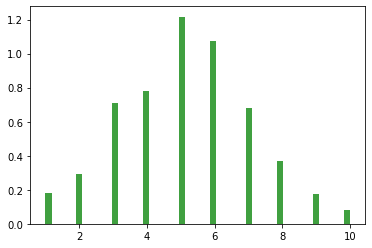

In [95]:
randomNums = np.maximum(1,np.minimum(np.random.normal(loc=5,scale=2, size=1000),10))
randomInts = np.round(randomNums)
n, bins, patches = plt.hist(randomInts, 50, density=True, facecolor='g', alpha=0.75)
plt.show()

In [94]:
np.random.normal()

0.5964651227533342